In [1]:
%%html
<link href='https://fonts.googleapis.com/css?family=Roboto' rel='stylesheet'>
<style>
body {
    font-family: 'Roboto', 'Helvetica', sans-serif; 
    font-size: 12px;
}
</style>

# **Clustering the Best of Reddit's Writing Prompts**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import altair as alt
import seaborn as sns
import re
import os
import json
import sqlite3
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from numpy.testing import assert_equal
from pywaffle import Waffle

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
import pickle

from PIL import Image

from IPython.display import HTML, display
import pprint

import warnings
warnings.filterwarnings('ignore')

# for wordclous
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Create toggle cell button
font = "Roboto-Regular.ttf"
pp = pprint.PrettyPrinter(indent=4, width=100)


HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

.output {
    display: flex;
    align-items: left;
    text-align: justify;
}

</style>


<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" 
value="Click here to toggle on/off the raw code."></form>
''')


In [4]:
# FUNCTIONS

def plot_cluster(X, y_predict, feature_names, this_month):
    """Plot the words that can be found in the cluster titles
    
    Input:
    df_c: tfid"""
    from wordcloud import WordCloud, STOPWORDS
    import math
    
    # Create df mapping TFIDF vectorized and the cluster assignment
    df_c = pd.DataFrame(X.toarray())
    df_c['cluster'] = y_predict
    
    c = list(set(y_predict))
    rows = math.ceil(len(c)/3)
    cols = 3
    fig, ax = plt.subplots(rows, cols, 
                           figsize=(15,5*rows), 
                           constrained_layout=True)

    for a in range(0,rows*cols):
        ax[a//3, a%3].axis('off')
        ax[a//3, a%3].get_xaxis().set_ticks([])
        ax[a//3, a%3].get_yaxis().set_ticks([])
    
    # For each of the clusters
    for i, each in enumerate(c):
        c_sum = df_c[df_c['cluster']==c[i]].sum(axis=0)
        data_cN = []
        for col, term in enumerate(feature_names):
            data_cN.append((term, c_sum[col]))

        ranking = pd.DataFrame(data_cN, columns=['term','rank'])
        rank1 = ranking.sort_values('rank', ascending=False)
        rank1[:500]
        

        df_f = rank1.set_index('term')

        # Generate wordcloud
        wordcloud = WordCloud(width = 300, height = 200, random_state=1, 
                              background_color='#323672', 
                              colormap='Set3', 
                              collocations=False, 
                              stopwords = STOPWORDS)
        wordcloud.generate_from_frequencies(frequencies=df_f['rank'])
        x = i//3
        y = i%3
        ax[x, y].set_title(f"Words for cluster: {each}")
        # Display image
        ax[x, y].imshow(wordcloud) 
        # No axis details
        ax[x, y].axis("off");
        
    plt.suptitle(f"Clusters for {this_month}")


In [5]:
# Retrieve data
all_data = pd.read_pickle(f"./data_postprocessed/svd_all_data.pkl")

<br><br>

# Executive Summary

Storytelling is a universal tradition apparent to all human kind. Ever since we as a species have learned to communicate with one another, we have been telling each other stories and the practice has been forever integrated into our society. Reddit’s **r/writingprompts** subreddit serves as a canvas for many aspiring writers looking for a hub for their creativity. The subreddit allows its members to post prompts that creatives can use to start writing stories. These prompts, when highly voted, serves as indicator of interest in those potential stories.

Using Informational Retrieval techniques such as TFIDF Vectorization, Singlular Value Decomposition, and Clustering, the SLT was able to describe the following clusters which represent the prevalent themes present in the posts with top 10% of upvotes in the subreddit per month.

These themes are:
1. **Extraterrestrial Science**, which has themes involving science fiction.
2. **Superheroes**, stemming from the superhero genre.
3. **Magic**, which features magic in our contemporary world or alternate realities. 
4. **Dungeons**, which stems from medieval fantasy.
5. **Occult**, which involves the paranormal.
6. **Death**, elements and plot devices with allusions to death.
7. **Time Travel**, themes involving time travel and time manipulation.

<br><br>

# Problem Statement

What are the prevalent themes in the highest rated prompts in reddt’s **r/writingprompts** subreddit? This report hopes to demonstrate the systematic aggregation of themes that can provide inspiration that was given by an interested audience who is asking for content.

<br><br>

# Data Description: Reddit

The reddit data is stored in a .zst file which contains a dictionary object with a single key as `RS_YYYY-MM`. This key has a list of all reddit posts for that month as its value. Each reddit post is represented as a dictionary having 82 keys which correspond to elements of a reddit post, for example: post title, number of comments, crossposts, etc. 

For this study, we want to gather the themes found in the writing prompts so we are limiting the scope to focus on the post title - which contains only the prompt. 

We are also considering the accompanying score for each post (which are simply upvotes - downvotes) which corresponds to an aggregate vote of approval or disapproval  from users. So within our scope, we will only be considering the posts with the top 10% of the scores.

<br><br>

# Methodology

Below is an overview of the methodology and steps performed in this study. We have an accompanying notebook, `02_Preprocessing_Recovered-FINAL.ipynb` which contains additional code of how the input files were prepared and executed. 

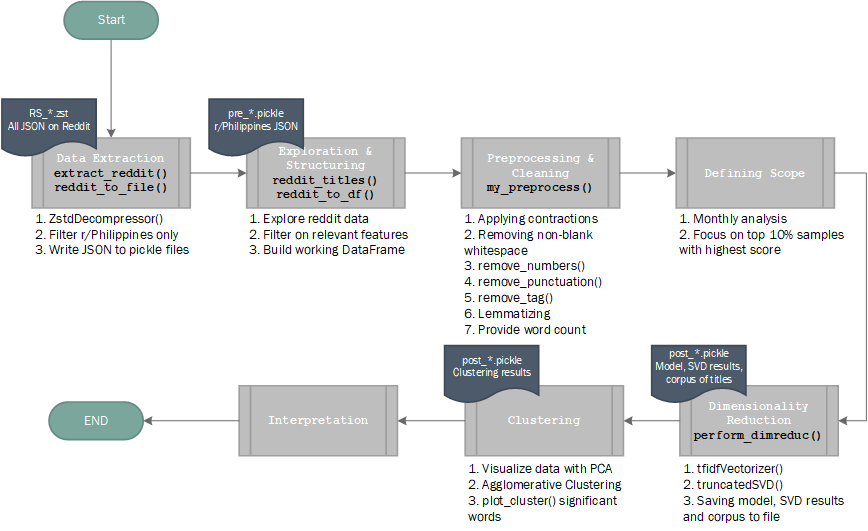

<div align="center"> <h4 align="center"> Figure 1 Methodology Flowchart </h4> </div>

## Data extraction

The datasets are webscrapes of monthly post titles and details from each post from all the subreddits on Reddit.com which were taken from AIM’s public dataset collection located in ```/mnt/data/public/reddit/submissions```. These are saved as dictionary strings in text files compressed as .zst files with the file name format of ```RS_YYYY-MM``` which indicates each file was a monthly collection of post information. The SLT decided to limit its scope to the months January to April 2020 as these are the most recent data available. 

Due to the large file sizes, decompression was an additional layer of complexity for our SLT because it was not possible to decompress and load the full file without exceeding the kernel memory. We used ```ZstdDecompressor``` from the zstandard package that allowed us to decompress the file at requests of a specified byte size that is within the kernel limitations. However there was no assurance that each requested and decompressed chunk was a complete json object and so there was required logic to piece together objects that may have been split among several chunks. For this, we leveraged available snippets provided online and by professors we consulted. Throughout the extraction, we paid attention to filter and store only the reddit entries that were relevant to the study to manage the volume during runtime. As such, we only needed to collect a manageable number of json objects at around 8,792 to a maximum of 9,242 objects from each file source file. All above steps were included in the function `extract_reddit` and `reddit_to_file` whose output was saved as pickle files in subfolder ```/data_preprocessed``` with filename format ```wp_RS_YYYY-MM.pkl```. The process of parsing the data into pickle files took just under 3 hours to run.

##  Exploration and Structuring

A second function, ```reddit_titles()``` was created to facilitate the reading of each of the month’s pickle files to create smaller json objects with keys that may be relevant to our study:

| Key |Data Type |Description | 
| :- | :- | :- | 
| title |String |Title of the post | 
| subreddit_subscribers|int |Number of reddit subscribers at the time | 
| created_utc |datetime |Creation date | 
| num_comments |int|Number of comments  | 
| score |int |Number of uplikes minus downlike of the post  | 
| over_18|boolean | Whether the post topic is for ages over 18 |


## Data Preprocessing

As with any topic modeling, it is important to ensure that we are working on a dataset that contains and is reduced to meaningful words. We performed the following steps in our function ```my_preprocess()``` that would run each text processing function and returns our corpus of cleaned post titles along with other information about our dataset. It is performing the following steps:

1. We used the package `contractions` to expand contractions to separate words for more accurate lemmatization and identification of stop words. For example, *wouldnt't* becomes *would not*.
2. Through regex, we removed whitespace characters such as tab, new line, etc so all words are separated by space
3. `remove_numbers()` removes symbols and numbers from the titles through regex.
4. `remove_punctuation()` removes punctuations not covered in remove_numbers() using regex. 
5.  `remove_tag()` removes the tag for the writing prompt. What are tags? In this particular subreddit, members are encouraged to use tags in the form of *[\<tag>]* as a convention on different kinds of posts example in figure below. Such are not relevant to the title itself and were removed through regex.

        WP: Writing Prompt
        SP: Simple Prompt
        EU: Established Universe
        CW: Constrained Writing
        TT: Theme Thursday
        PM: Prompt Me
        MP: Media Prompt
        IP: Image Prompt
        PI: Prompt Inspired
        OT: Off Topic
        * OT as an Advertisement!
        RF: Reality Fiction
        

6. `lemmatize_text` package was applied to the titles to simplify variations of the word into their dictionary form, thus improving TFIDF and SVD results.
7. Lastly, we provide some simple statistics of the number of characters and words that are remaining to the cleaned title.

**Stop Words.** Since we were dealing with a subreddit written in the English Language, we removed English stopwords at a later step together with vectorization in TfidfVectorizer. We used text.ENGLISH_STOP_WORDS and added additional words that we identified during initial EDA that were not captured and acted as noise.

**Summary:**<br><br>
In summary for Initial EDA, the `pre_processing` provides high level number of titles and words as seen in the succeeding charts. In total, we gathered 36,377 posts with the following breakdown per month:

Resulting DataFrame sample:

In [6]:
# Retrieve 
df = pd.read_pickle(f"./data_postprocessed/df_all.pkl")
df.head()

month                                             titles  subscribers  \
0  2020-01  [wp] you enter the barred gates into a lusciou...     14367885   
1  2020-01  [wp]                      happy new ye   wait ...     14367885   
2  2020-01  [wp] you just won the big jackpot   billion do...     14367885   
3  2020-01  [sp] a retired supervillain becomes a citys un...     14367886   
4  2020-01  [wp] the galaxy is in shambles after one stupi...     14367886   

          create_date  comments  score   18up   tag  \
0 2020-01-01 00:00:58         1     15  False  [wp]   
1 2020-01-01 00:01:38         2      7  False  [wp]   
2 2020-01-01 00:02:13         3     73  False  [wp]   
3 2020-01-01 00:06:51         1     13  False  [sp]   
4 2020-01-01 00:07:36         1      7  False  [wp]   

                                         clean_title  \
0  you enter the barred gate into a luscious extr...   
1  happy new ye wait what everyone suddenly disap...   
2  you just won the big jackpot billion dollar yo...   
3  a retired supervillain becomes a city unlikely...   
4  the galaxy is in shamble after one stupid race...   

                                           tokenized  chars  words  
0  [you, enter, the, barred, gate, into, a, lusci...    268     49  
1  [happy, new, ye, wait, what, everyone, suddenl...     52      8  
2  [you, just, won, the, big, jackpot, billion, d...    164     29  
3  [a, retired, supervillain, becomes, a, city, u...     56      9  
4  [the, galaxy, is, in, shamble, after, one, stu...    123     20

In [7]:
df.groupby('month')['clean_title'].count().to_frame()

clean_title
month               
2020-01         9196
2020-02         8792
2020-03         9242
2020-04         9147

<div align="center"> <h4 align="center"> Figure 2 Summarized Reddit info as Dataframe </h4> </div>

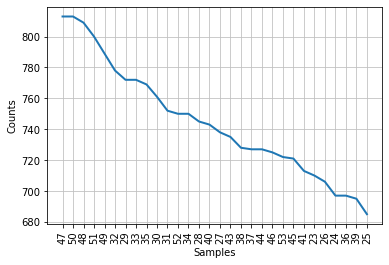

In [8]:
# plot of word frequency
fdist = FreqDist(df['words'])
fdist.plot(30, cumulative=False)
plt.show()

<div align="center"> <h4 align="center"> Figure 3 Frequency of Titles with their word count  </h4> </div>

Majority of the titles span from 25 to 55 words. Very few titles maximize the word count at 60+ words consistently every month. Given this consistent pattern among the months, we did not do any removal of outliers or extremes for our dataset.

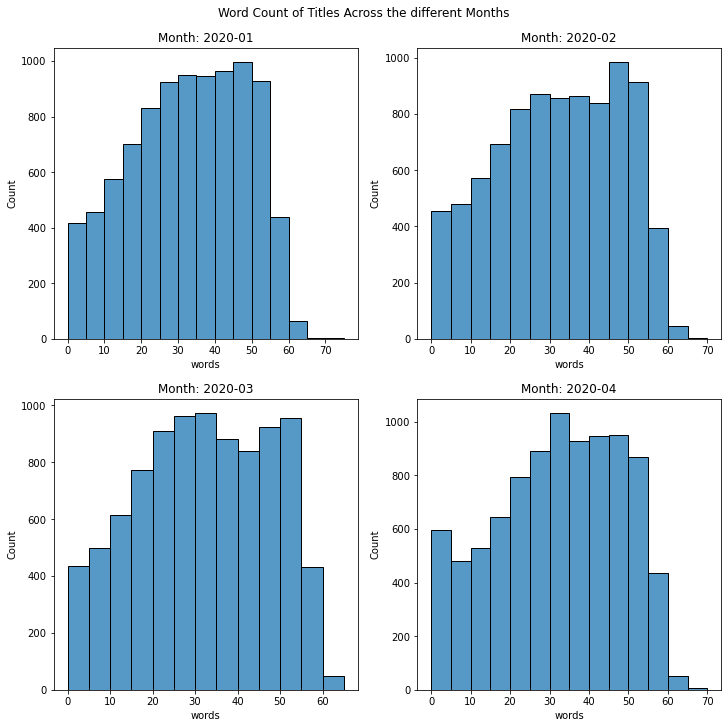

In [9]:
# histogram of words per month:

fig, ax = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)
fig.suptitle("Word Count of Titles Across the different Months")
# (f'{plt_title}')
for j, i in enumerate(df['month'].unique()):    
    # histogram of number of words per title
    sns.histplot(data=df[df['month']==i], x="words", binwidth=5, 
                 ax=ax[j//2, j%2])
    ax[j//2, j%2].set_title(f"Month: {i}")
    
#     plt.title(f"Month: {i}")

#     plt.show()

## Defining the Scope

With over 36 thousand titles, we had to limit the scope of the study to within the capacity of the system. As such, we approached our analysis on a per month and primarily focusing on the titles that scored in the top 10% of each month.

| Month |Total Titles | 10% in scope | 
| :- | :- | :- | 
| 2020-01 |9,196 |919| 
| 2020-02|8,792 |879| 
| 2020-03 |9,242 |924| 
| 2020-04 |9,147|914| 

<br><br>
Looking at the scatterplot in `Figure X` the highest scores fall within range of 30 to 50 words in the title.

In [10]:
# DATA PREPARATION
# January
jan = df[df['month']=='2020-01']
df1 = df[df['month'] == '2020-01']
df1 = df1.sort_values('score',ascending=False).head(int(df1.shape[0]*.1))
df1['flag'] = True
jan['In Scope'] = df1['flag']
jan['In Scope'] = jan['In Scope'].fillna('False')

# Feb
feb = df[df['month']=='2020-02']
df2 = df[df['month'] == '2020-02']
df2 = df2.sort_values('score',ascending=False).head(int(df2.shape[0]*.1))
df2['flag'] = True
feb['In Scope'] = df2['flag']
feb['In Scope'] = feb['In Scope'].fillna('False')

# March
mar = df[df['month']=='2020-03']
df3 = df[df['month'] == '2020-03']
df3 = df3.sort_values('score',ascending=False).head(int(df3.shape[0]*.1))
df3['flag'] = True
mar['In Scope'] = df3['flag']
mar['In Scope'] = mar['In Scope'].fillna('False')

# April
apr = df[df['month']=='2020-04']
df4 = df[df['month'] == '2020-04']
df4 = df4.sort_values('score',ascending=False).head(int(df4.shape[0]*.1))
df4['flag'] = True
apr['In Scope'] = df4['flag']
apr['In Scope'] = apr['In Scope'].fillna('False')

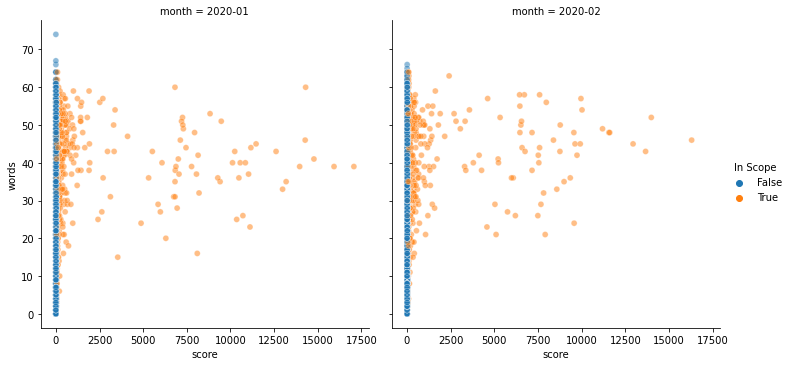

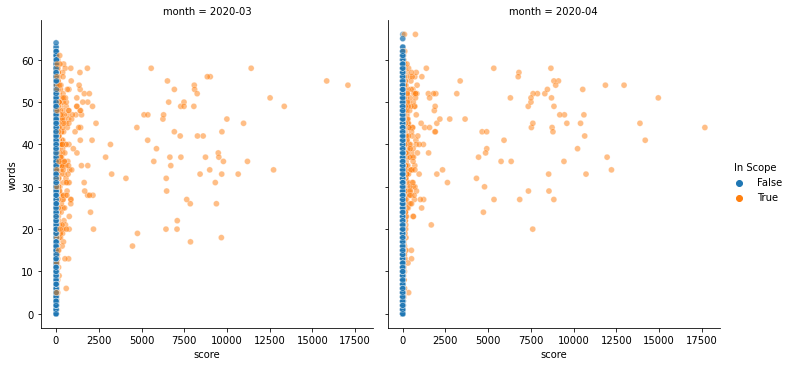

In [11]:
sns.relplot(
    data=jan.append(feb), y="words", x="score",
    col="month", kind="scatter", alpha=.5,
    hue ="In Scope"
)
sns.relplot(
    data=mar.append(apr), y="words", x="score",
    col="month", kind="scatter", alpha=.5,
    hue ="In Scope"
);

## Dimensionailty Reduction

Now having a complete and clean list of reddit titles, we next want them to be represented as a matrix having each reddit title as the row while each column as the words. We opted for **Term Frequency-Inverse Document Frequency or TF-IDF** so that it provides a numerical value representative of the importance of each word with respect to the whole title (the higher, the more important). To reduce the number of features to specific topics, we went for **Latent Semantic Analysis or LSA** since this is appropriate for sparse matrices and can provide as an output mapping of which are words that are strongly and inversely related as guidance in identifying the topics.


### Vectorizing with ```TfidfVectorizer```

Given that TfidfVectorizer also performs tokenization, here is our approach and results in tuning the parameters:
* Enabling stopwords for English with our own English Stop word list 
* Max_df = 0.9 to remove words that appear in more than 90% of the documents to remove potential noise that may not be included in the stopwords


We performed vectorization separately for each month. After Vectorization, we have the following words identified in the features:

* 2020-01: Rows = 919 and Words = 4873
* 2020-02: Rows = 879 and Words = 4798
* 2020-03: Rows = 924 and Words = 4689
* 2020-04: Rows = 914 and Words = 4747



**N-Grams**<br>
In our previous study of Reddit one of our recommendation was to use bigrams. In a few iterations these proved to be effective in giving more meaningful SVs after TruncatedSVD, however the clustering struggled to find relationships between the bigrams with the uniqueness of the combinations. Thus, we opted not to use bigrams for this study and consider each word individually. 


### LSA with ```TruncatedSVD``` 

To reduce the number of features to specific topics, we went for Latent Semantic Analysis or LSA since this is appropriate for sparse matrices and can provide as an output mapping of which are words that are strongly and inversely related as guidance in identifying the topics.

* 2020-01: SV's to retain:693 for 90.0% Explained Variance
* 2020-02: SV's to retain:671 for 90.0% Explained Variance
* 2020-03: SV's to retain:697 for 90.0% Explained Variance
* 2020-04: SV's to retain:689 for 90.0% Explained Variance


### Final parameters

Below are the final parameters we used:

**Parameters for TFIDF**

|Parameter |Value |Comments|
| :- | :- | :- | 
|stop_words|'english'|Enable removal of stop words from English dictionary|
|max_df|0.9|Remove words appearing in more than 90% of titles|


**Parameters for LSA**

|Parameter |Value |Comments|
| :- | :- | :- | 
|n_components|no. features - 1 | Maximum features that can be included|


## Post Processing

Information from pre-processing as well as after dimensionality reduction are stored in pickle files for purpose of EDA and visualization. All these are stored in the folder ```./data_postprocessed```:

* `df_all.pkl` - contain final working DataFrame and general information about all four months cleaned data combined. 
* `corpus_arr.pkl` - contains list of the corpus of each month's corpus for input in dimensionality reduction step
* `svd_all_data` - contains list of dictionaries for each month containing the models, transformed tables, etc after dimensionality reduction step `perform_dimreduc()`. Below is sample dictionary for each month

        dict_dimreduc['vectorizer'] = vectorizer
        dict_dimreduc['X'] = X
        dict_dimreduc['svd_model'] = svd_model
        dict_dimreduc['X_new'] = X_new
        dict_dimreduc['feature_names'] = feature_names
        dict_dimreduc['Sigma'] = svd_model.singular_values_
        dict_dimreduc['V_T'] = svd_model.components_.T
        dict_dimreduc['nssd'] = svd_model.explained_variance_ratio_

<br><br>

# Clustering and Interpretation

The matrix was then placed in a cosine distance function to give better results when clustering. The resulting matrix was then fed into a package for the Ward's method clustering algorithm and plotted using a dendogram to visulaize the potential clusters.

The data is also visualized through PCA to give an idea of the number of clusters.

The clusters formed by the dendograms were then visualized using Wordclouds and interpreted by the group.

This was done for each month and plotted bellow.

## January 2020

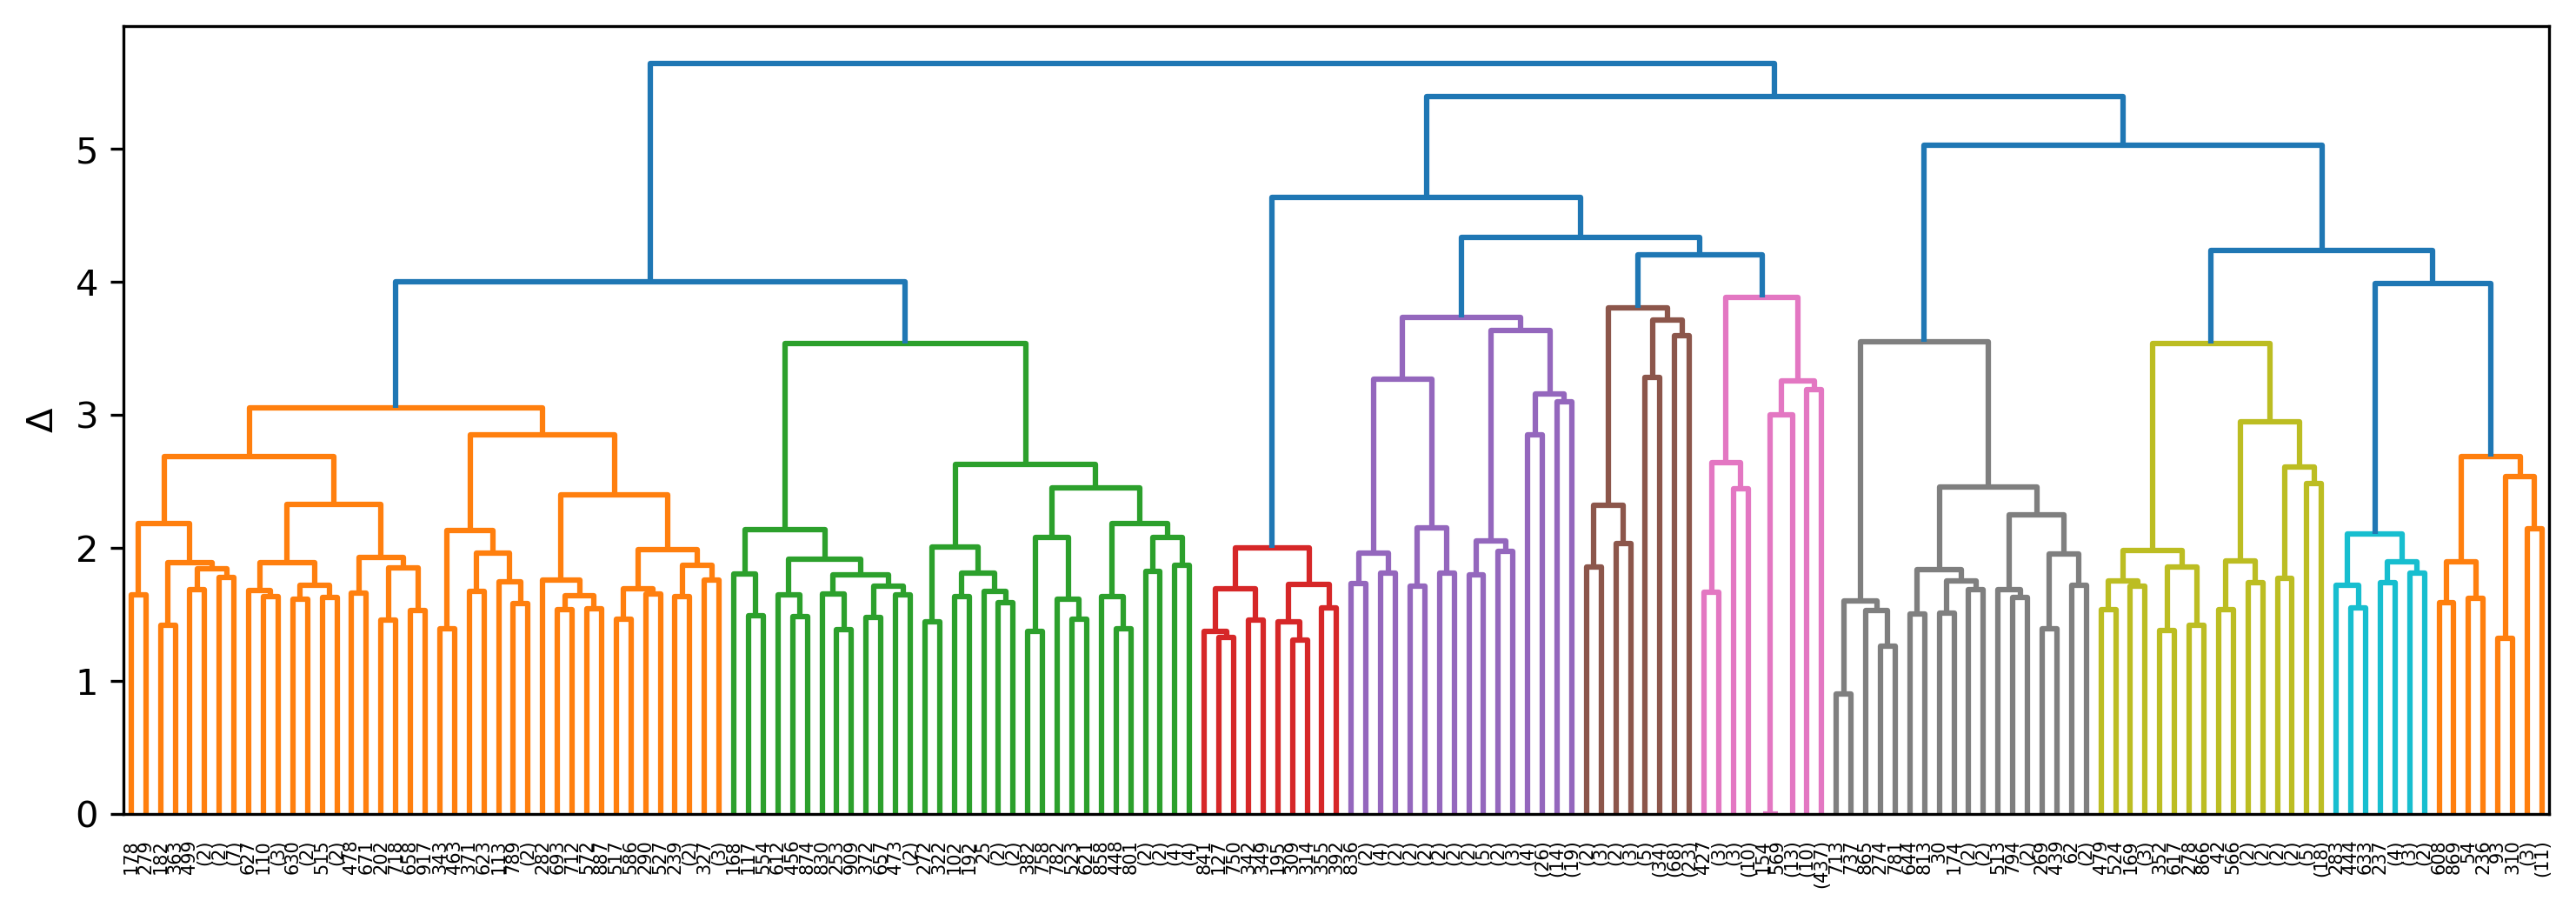

In [12]:
# Retrieve data
c1 = pd.read_pickle(f"./data_postprocessed/cluster1.pkl")

# Plot truncated dendogram
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(c1['linkage_matrix'], ax=ax, truncate_mode='level', p=7)
ax.set_ylabel(r'$\Delta$');

<div align="center"> <h4 align="center"> Figure 4 Dendogram for Jan 2020 </h4> </div>

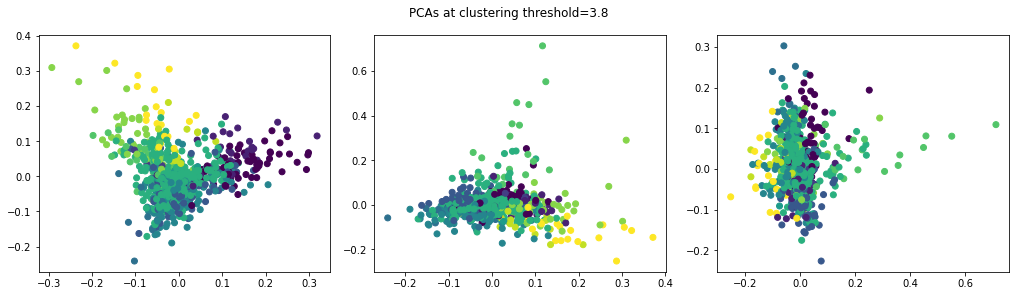

In [13]:
# Let's visualize on PCs
X_pca = PCA(n_components=4, random_state=1337).fit_transform(all_data[0]['X_new'])

# color represents the cluster given the specified threshold
# Threshold:
thres = 3.8
y_predict1 = c1['y_predict']

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_predict1)
ax[1].scatter(X_pca[:,1], X_pca[:,2], c=y_predict1)
ax[2].scatter(X_pca[:,2], X_pca[:,3], c=y_predict1)
plt.suptitle(f"PCAs at clustering threshold={thres}");


<div align="center"> <h4 align="center"> Figure 5 PCA Plot for Jan 2020 </h4> </div>

In [14]:
# Display distribution/count for each cluster

df_clustered = pd.DataFrame(all_data[0]['X'].toarray())
df_clustered['cluster'] = y_predict1
df_temp = df_clustered['cluster'].value_counts().to_frame().reset_index()
df_temp.columns=['cluster number', 'count']
df_temp

cluster number  count
0                8    462
1                6    130
2                4     92
3                1     57
4                2     43
5               10     43
6                9     22
7               12     20
8                7     17
9               11     13
10               3     10
11               5     10

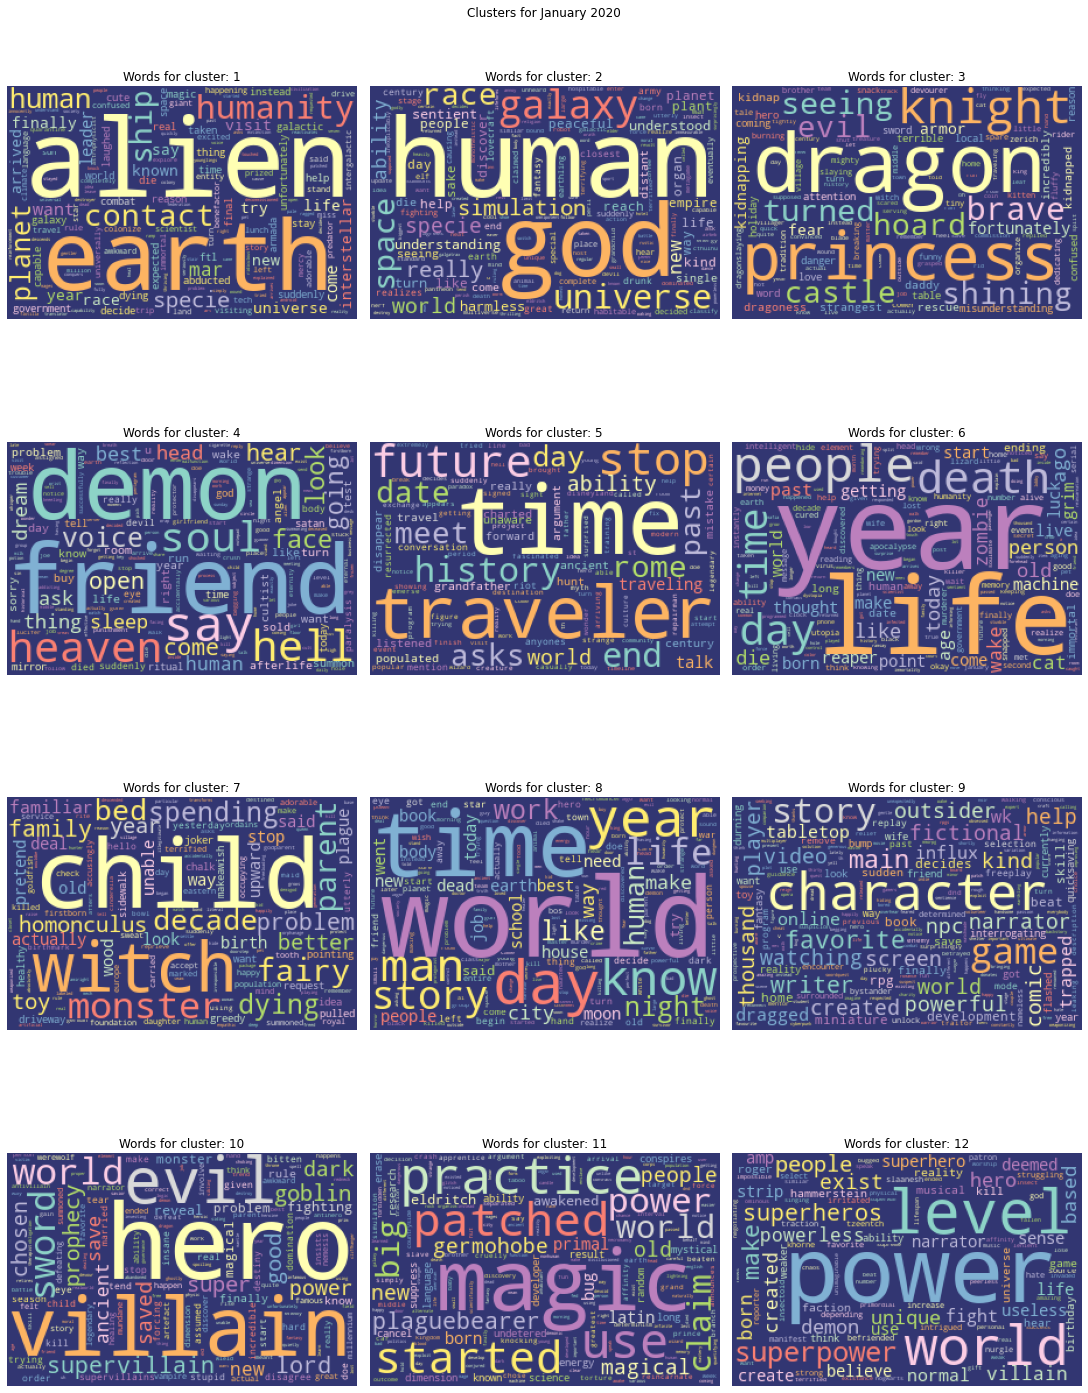

In [15]:
plot_cluster(all_data[0]['X'], y_predict1, all_data[0]['feature_names'], 'January 2020')

<div align="center"> <h4 align="center"> Figure 6 Word Cloud for Jan 2020 </h4> </div>

**January 2020**

**Cluster 1 (Extraterrestrial Science Fiction)** - Has the features: alien, earth, contact, planet, ships, etc. which suggests the themes of interplanetary travel and extraterrestrial life. Interstellar, the title of the Christopher Nolan Film, is also present in the features and may be present as adapted fiction or mentioned as an inspiration.

**Cluster 2 (Other Worlds)** - Has the features of human, god, race, universe, galaxy, space, simulation, sentient, etc. which suggests themes of worlds beyond ours and the entities that reside there.

**Cluster 3 (Dungeon Fantasy)** - Has the features dragon, knight, princess, castle, etc. which is common in the traditional medieval fantasy settings.

**Cluster 4 (Occult Fiction)** - Has the features demon, friend, heaven, hell, soul, afterlife, cultist, ritual, summon, etc. which suggest themes with occult elements, possibly for horror and fantasy.

**Cluster 5 (Time Travel)** - Has the features time, traveler, history, future, day, ancient, etc. which implies themes of traveling through time or time manipulation.

**Cluster 6 (Death)** - Has the features year, life, grim, reaper, death, immortal, etc. which suggest plot elements about death or having a limited time to live.

**Cluster 7 (Family Fantasy)** - Has the features child, witch, parent, monster, fairy, but also has elements like homunculus, plague, monster, which follows the themes of fantasy and possibly families as plot elements or characters.

**Cluster 8 (Noise)** - This cluster looks like noise and features many words that could be used in setting up a situation to a prompt. Words like story, time, year, world, night, etc.

**Cluster 9 (Media Inspired)** - Has features referencing other mediums such as game, comic, tabletop, etc. and elements from those mediums may have inspired these the prompts which provided these features.

**Cluster 10 (Dungeons Fantasy)** - This clusters is similar to Cluster 3 in January

**Cluster 11 (Magic Fantasy)** - Has features like practice, magic, power, world, etc. which suggests themes of magic.

**Cluster 12 (Superhero Fiction)** - Has the features power, superpower, superheroes, villain, which follows the themes of superheroes present in comics are related media.

<br><br>

## February 2020

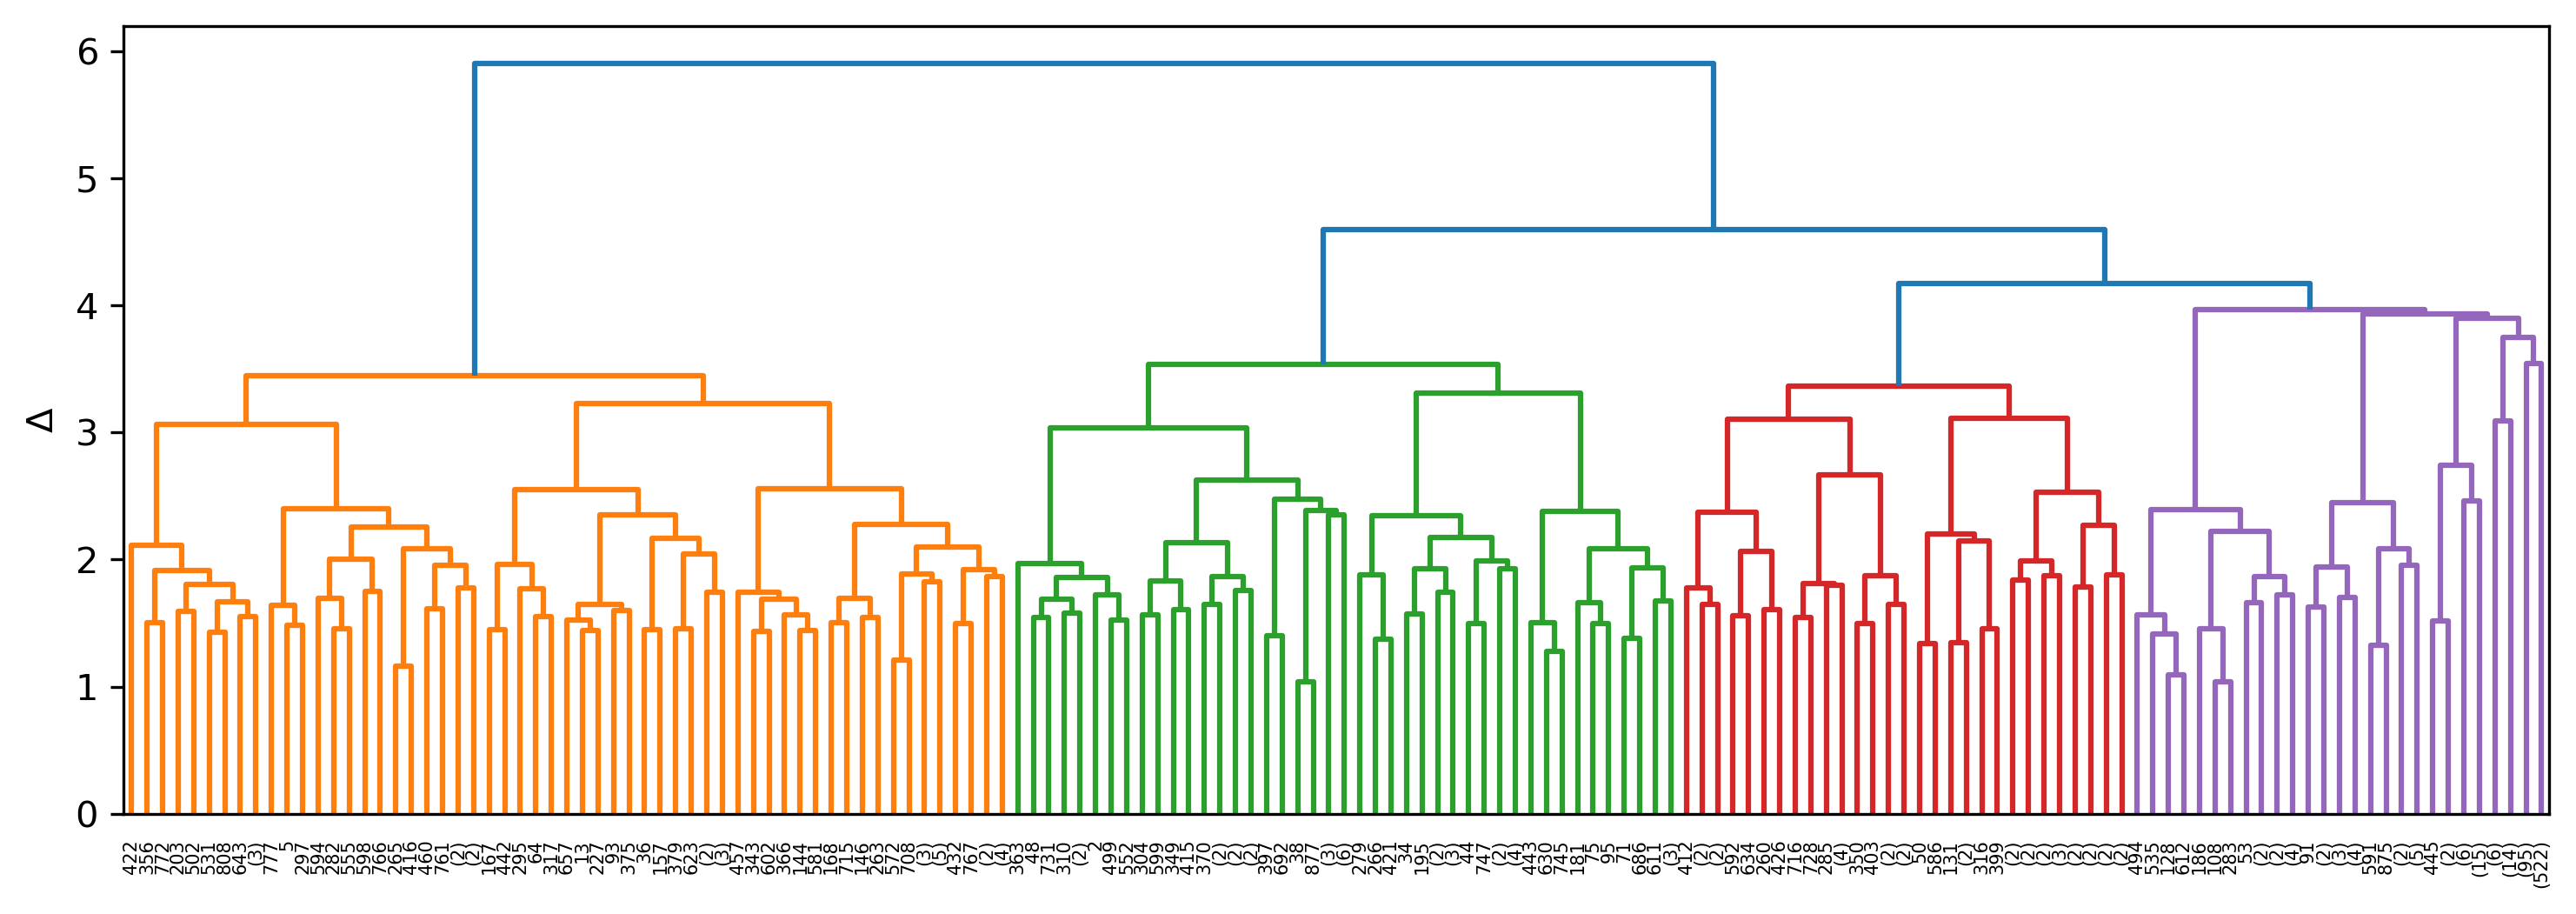

In [16]:
# Retrieve data
c2 = pd.read_pickle(f"./data_postprocessed/cluster2.pkl")

# Display trucnated dendogram
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(c2['linkage_matrix'], ax=ax, truncate_mode='level', p=7)
ax.set_ylabel(r'$\Delta$');

<div align="center"> <h4 align="center"> Figure 7 Dendogram for Feb 2020 </h4> </div>

Text(0.5, 0.98, 'PCAs at threshold=3.5')

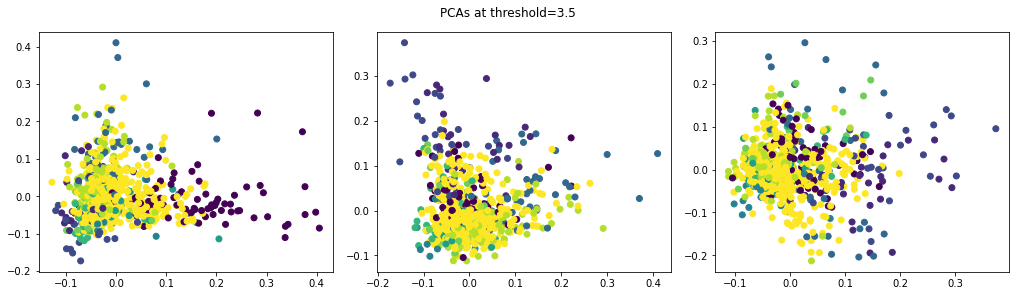

In [17]:
# Execute PCA for visualization 
X_pca = PCA(n_components=4, random_state=1337).fit_transform(all_data[1]['X_new'])

# Let's visualize on the 2 PCs
# color represents the cluster given the specified threshold
# Threshold:
thres = 3.5

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=c2['y_predict'])
ax[1].scatter(X_pca[:,1], X_pca[:,2], c=c2['y_predict'])
ax[2].scatter(X_pca[:,2], X_pca[:,3], c=c2['y_predict'])
plt.suptitle(f"PCAs at threshold={thres}")

<div align="center"> <h4 align="center"> Figure 8 PCA Plot for Feb 2020 </h4> </div>

In [18]:
# Display distribution/count for each cluster

df_clustered = pd.DataFrame(all_data[1]['X'].toarray())
df_clustered['cluster'] = c2['y_predict']
df_clustered['cluster'].value_counts()
df_temp = df_clustered['cluster'].value_counts().to_frame().reset_index()
df_temp.columns=['cluster number', 'count']
df_temp

cluster number  count
0              10    522
1               9     95
2               1     74
3               4     46
4               2     33
5               3     30
6               7     24
7               8     20
8               6     19
9               5     16

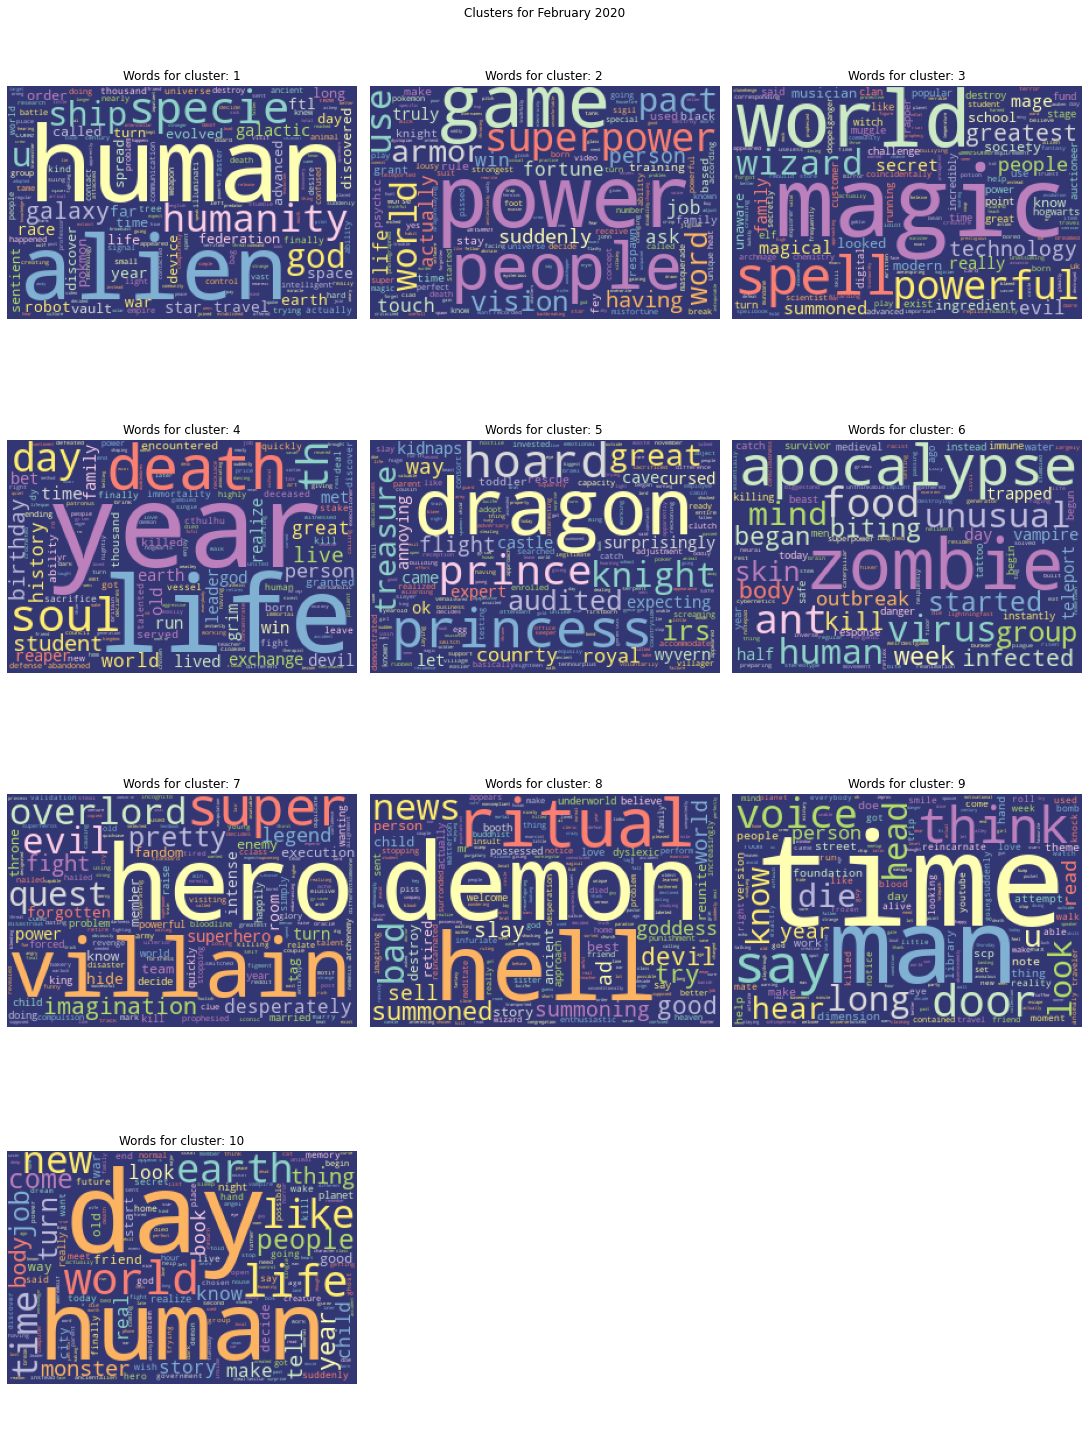

In [19]:
plot_cluster(all_data[1]['X'], c2['y_predict'], all_data[1]['feature_names'], 'February 2020')

<div align="center"> <h4 align="center"> Figure 9 World Cloud for Feb 2020 </h4> </div>

**February 2020**

**Cluster 1 (Extraterrestrial Science Fiction)** - similar to Cluster 3 in Jan.


**Cluster 2 (Superhero Fiction)** - similar to Cluster 12 in Jan.

**Cluster 3 (Magical Fantasy)** - similar to Cluster 11 in Jan, but has other features associated with the genre like magic, spell, world, wizard, powerful, school, summoned, etc.

**Cluster 4 (Death)** - similar to Cluster 6 in Jan.

**Cluster 5 (Dungeon Fantasy)** - similar to Cluster 3 in Jan.

**Cluster 6 (Zombies)** - has the features zombie, apocalypse virus, infected, outbreak, etc. suggesting themes with the zombie apocalypse genre.

**Cluster 7 (Superhero)** - similar to Cluster 12 in Jan, but has other features associated with the genre like evil, overlord, fight, etc.

**Cluster 8 (Occult)** - similar to Cluster 4 in Jan.

**Cluster 9 (Noise)** - similar to Cluster 8 in Jan.

**Cluster 10 (Noise)** - similar to Cluster 8 in Jan.

<br><br>

## March 2020

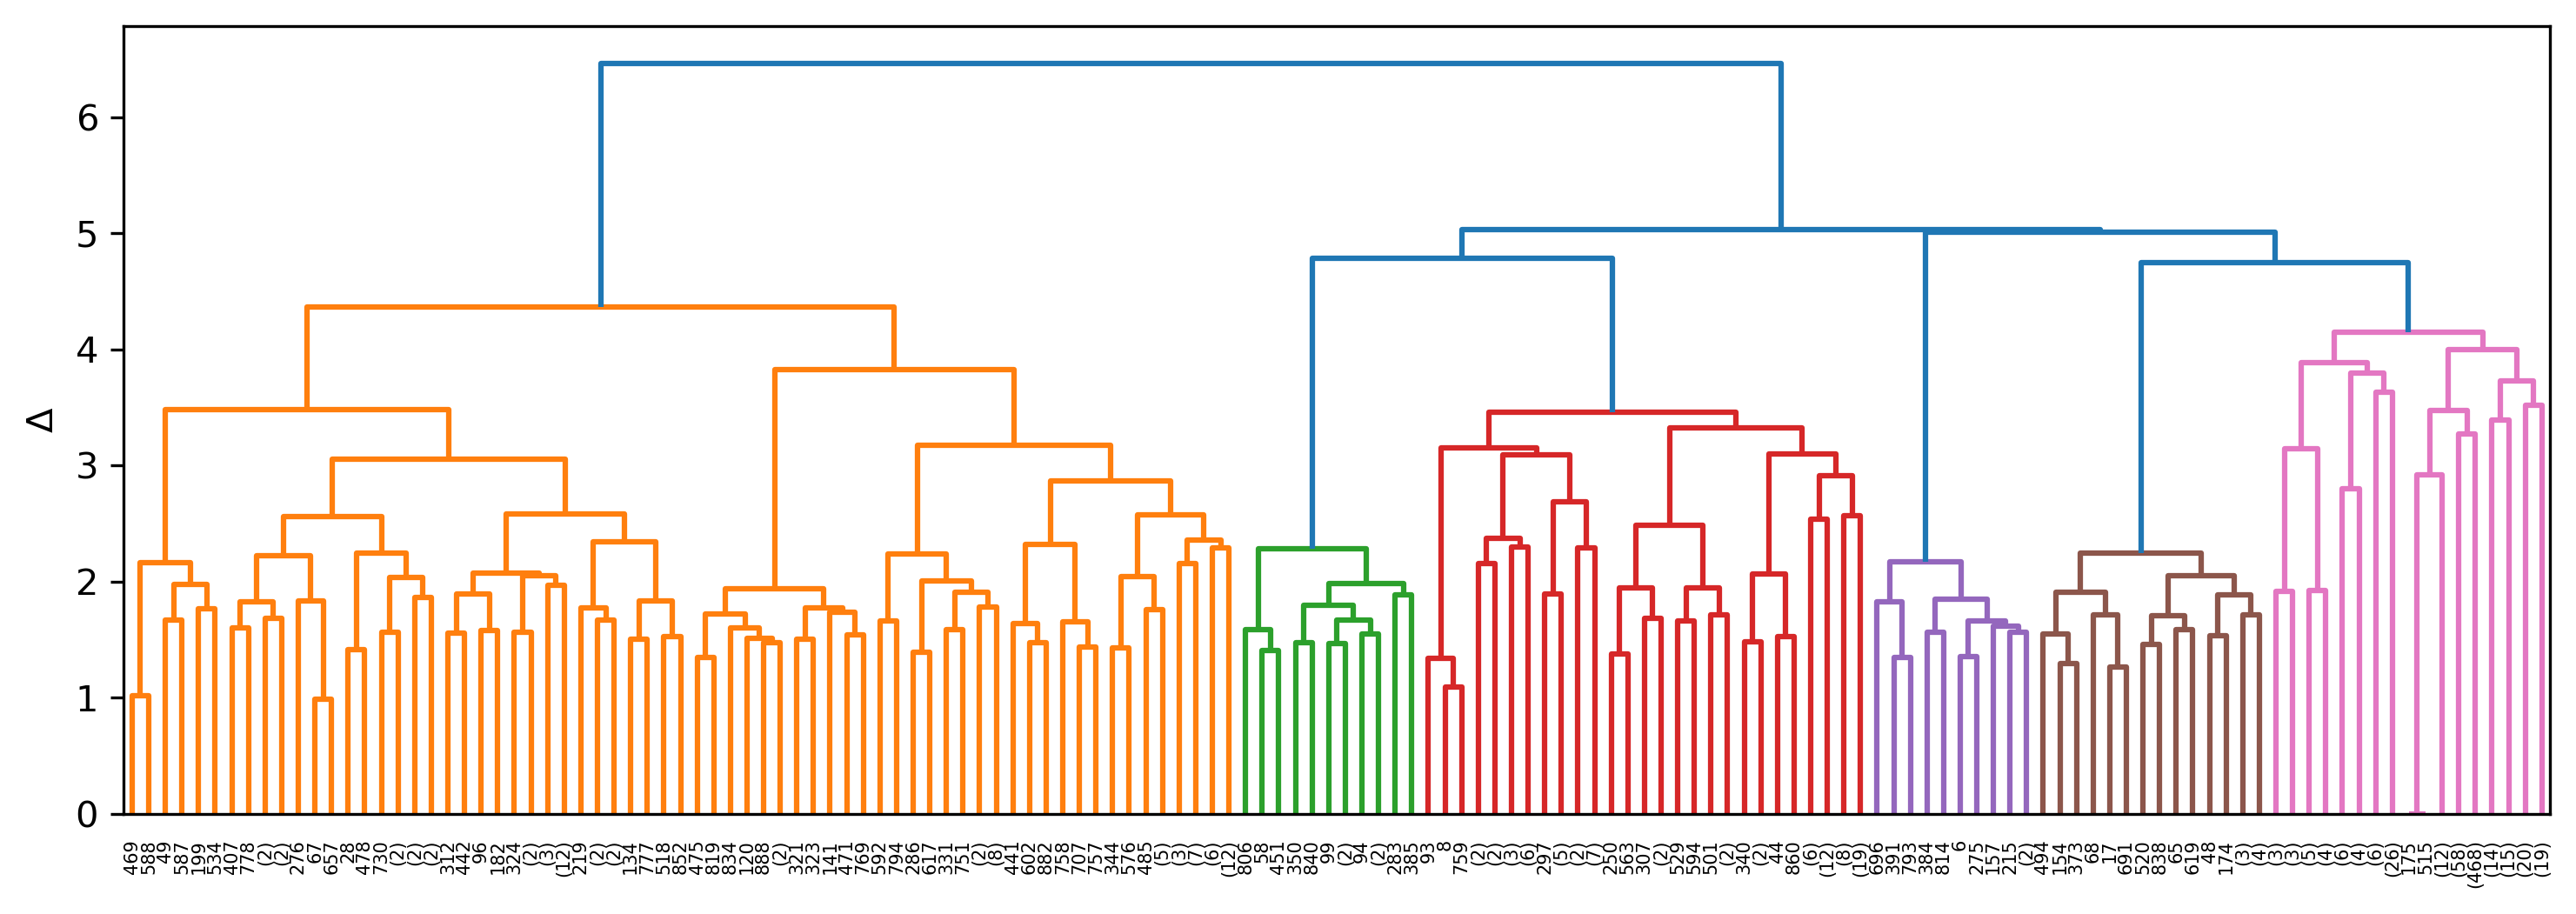

In [20]:
# Retrieve data
c3 = pd.read_pickle(f"./data_postprocessed/cluster3.pkl")

# show trncated dendogram
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(c3['linkage_matrix'], ax=ax, truncate_mode='level', p=7)
ax.set_ylabel(r'$\Delta$');

<div align="center"> <h4 align="center"> Figure 10 Dendogram for Mar 2020 </h4> </div>

Text(0.5, 0.98, 'PCAs at Threshold=4')

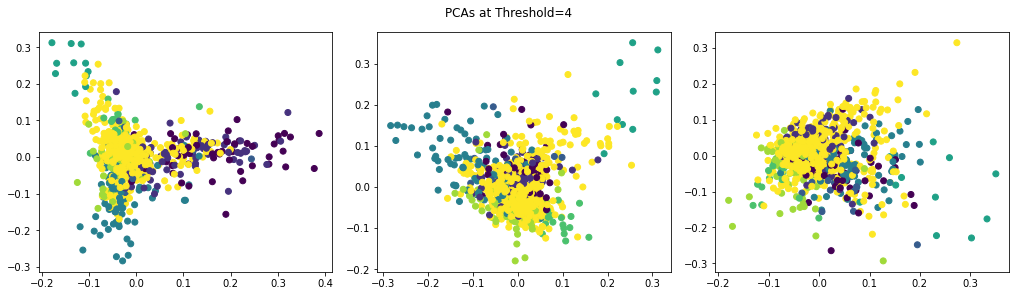

In [21]:
# Visualizing the clusters on the first few PCs
X_pca = PCA(n_components=4, random_state=1337).fit_transform(all_data[2]['X_new'])

# Threshold:
thres = 4

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=c3['y_predict'])
ax[1].scatter(X_pca[:,1], X_pca[:,2], c=c3['y_predict'])
ax[2].scatter(X_pca[:,2], X_pca[:,3], c=c3['y_predict'])
plt.suptitle(f"PCAs at Threshold={thres}")

<div align="center"> <h4 align="center"> Figure 11 PCA Plot for Mar 2020 </h4> </div>

In [22]:
# Display distribution/count for each cluster

df_clustered = pd.DataFrame(all_data[2]['X'].toarray())
df_clustered['cluster'] = c3['y_predict']
df_temp = df_clustered['cluster'].value_counts().to_frame().reset_index()
df_temp.columns=['cluster number', 'count']
df_temp

cluster number  count
0               8    608
1               4     91
2               2     70
3               7     57
4               1     55
5               6     19
6               3     13
7               5     11

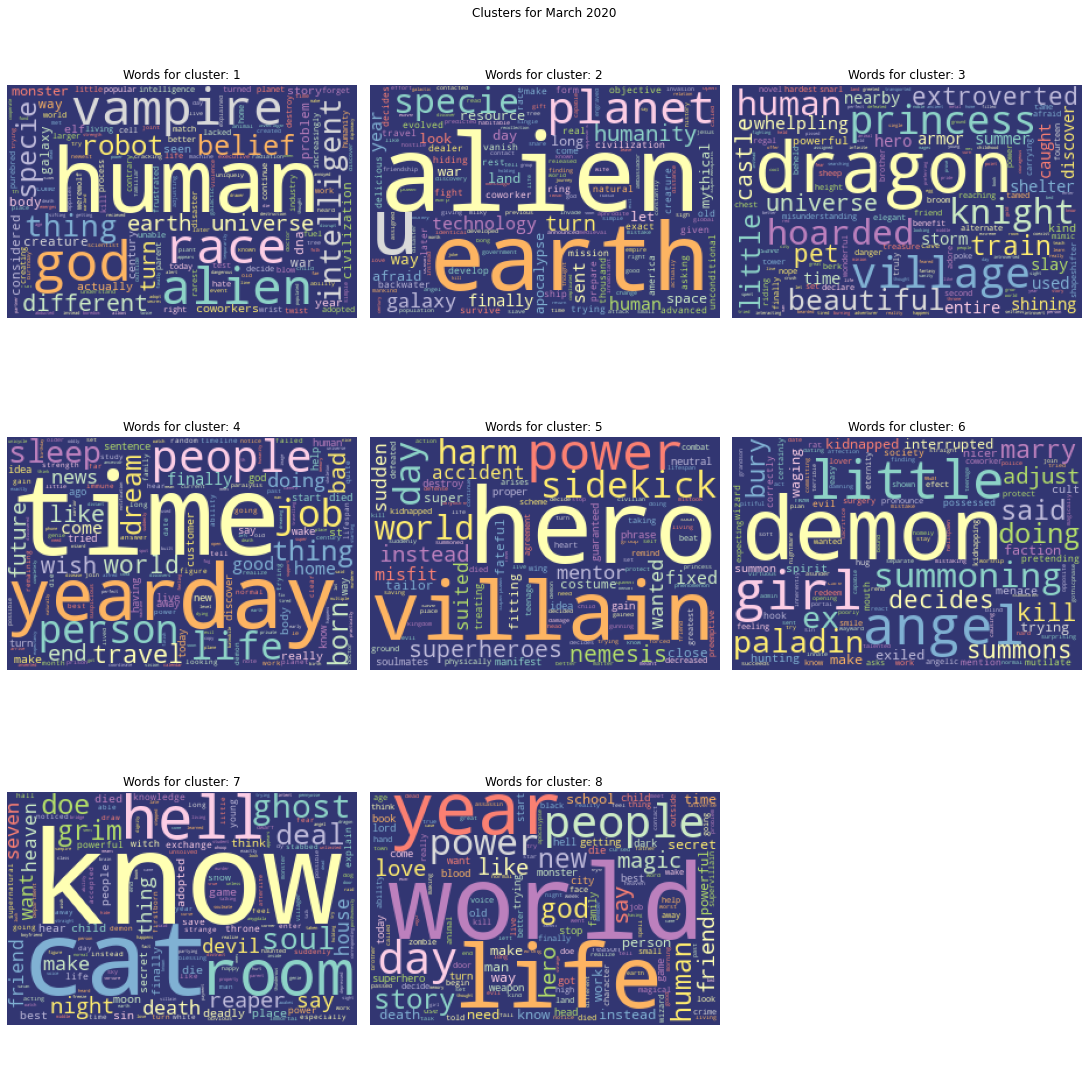

In [23]:
plot_cluster(all_data[2]['X'], c3['y_predict'], all_data[2]['feature_names'], 'March 2020')

<div align="center"> <h4 align="center"> Figure 12 Word Cloud for Mar 2020 </h4> </div>

**March 2020**

**Cluster 1 (Cross Genre)** – has features similar to Extraterrestrial Science Fiction but has the feature vampire.

**Cluster 2 (Extraterrestrial Science Fiction)** – similar to Cluster 1 in Jan.

**Cluster 3 (Dungeon Fantasy)** - similar to Cluster 3 in Jan.

**Cluster 4 (Time Travel)** - similar to Cluster 5 in Jan.

**Cluster 5 (Superheroes)** - similar to Cluster 12 in Jan, with the additional features of sidekick, nemesis, mentor, wanted, etc.

**Cluster 6 (Occult)** - similar to Cluster 4 in Jan, with the additional features of paladin

**Cluster 7 (Paranormal)** - has features cat, hell, room, ghost, demon, devil, reaper, grim, which suggest themes of the supernatural and paranormal.

**Cluster 8 (Noise)** – similar to Cluster 8 in Jan.

<br><br>

## April 2020

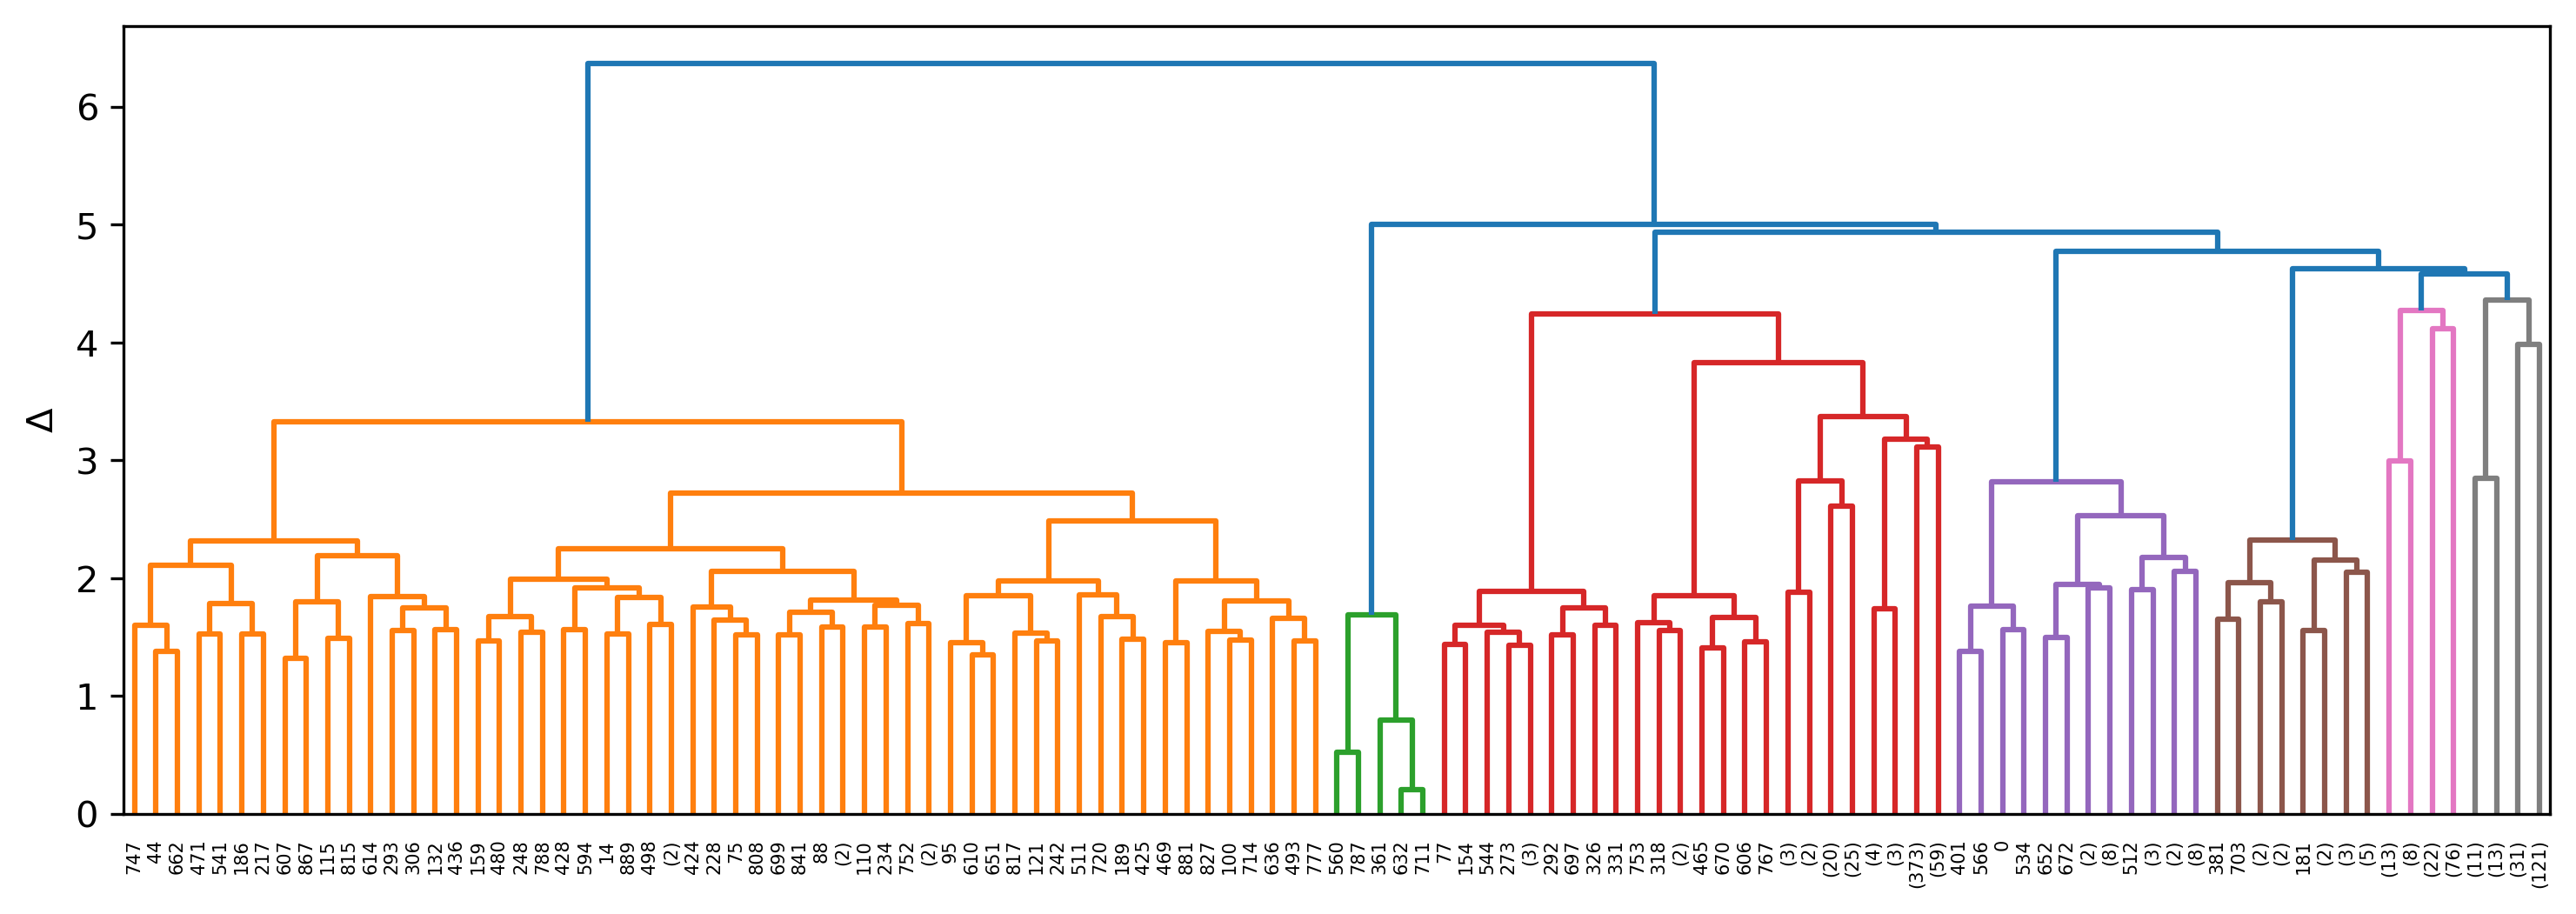

In [24]:
# Retrieve data
c4 = pd.read_pickle(f"./data_postprocessed/cluster4.pkl")

# Display on truncated dendogram
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(c4['linkage_matrix'], ax=ax, truncate_mode='level', p=7)
ax.set_ylabel(r'$\Delta$');

<div align="center"> <h4 align="center"> Figure 13 Dendogram for Apr 2020 </h4> </div>

Text(0.5, 0.98, 'PCAs at threshold=3.8')

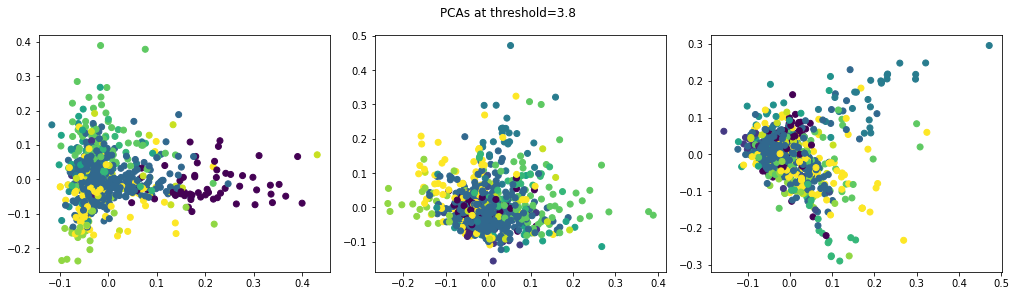

In [25]:
X_pca = PCA(n_components=4, random_state=1337).fit_transform(all_data[3]['X_new'])

# Let's visualize on the first few PCs
# color represents the cluster given the specified threshold

# Threshold:
thres = 3.8

fig, ax = plt.subplots(1,3, figsize=(14,4), constrained_layout=True)
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=c4['y_predict'])
ax[1].scatter(X_pca[:,1], X_pca[:,2], c=c4['y_predict'])
ax[2].scatter(X_pca[:,2], X_pca[:,3], c=c4['y_predict'])
plt.suptitle(f"PCAs at threshold={thres}")

<div align="center"> <h4 align="center"> Figure 14 PCA Plot for Apr 2020 </h4> </div>

In [26]:
# Display distribution/count for each cluster


df_clustered = pd.DataFrame(all_data[3]['X'].toarray())
df_clustered['cluster'] = c4['y_predict']
df_temp = df_clustered['cluster'].value_counts().to_frame().reset_index()
df_temp.columns=['cluster number', 'count']
df_temp

cluster number  count
0                5    489
1               13    121
2               10     76
3                1     59
4               12     31
5                6     30
6               11     24
7                9     22
8                8     21
9                7     17
10               3     11
11               4      8
12               2      5

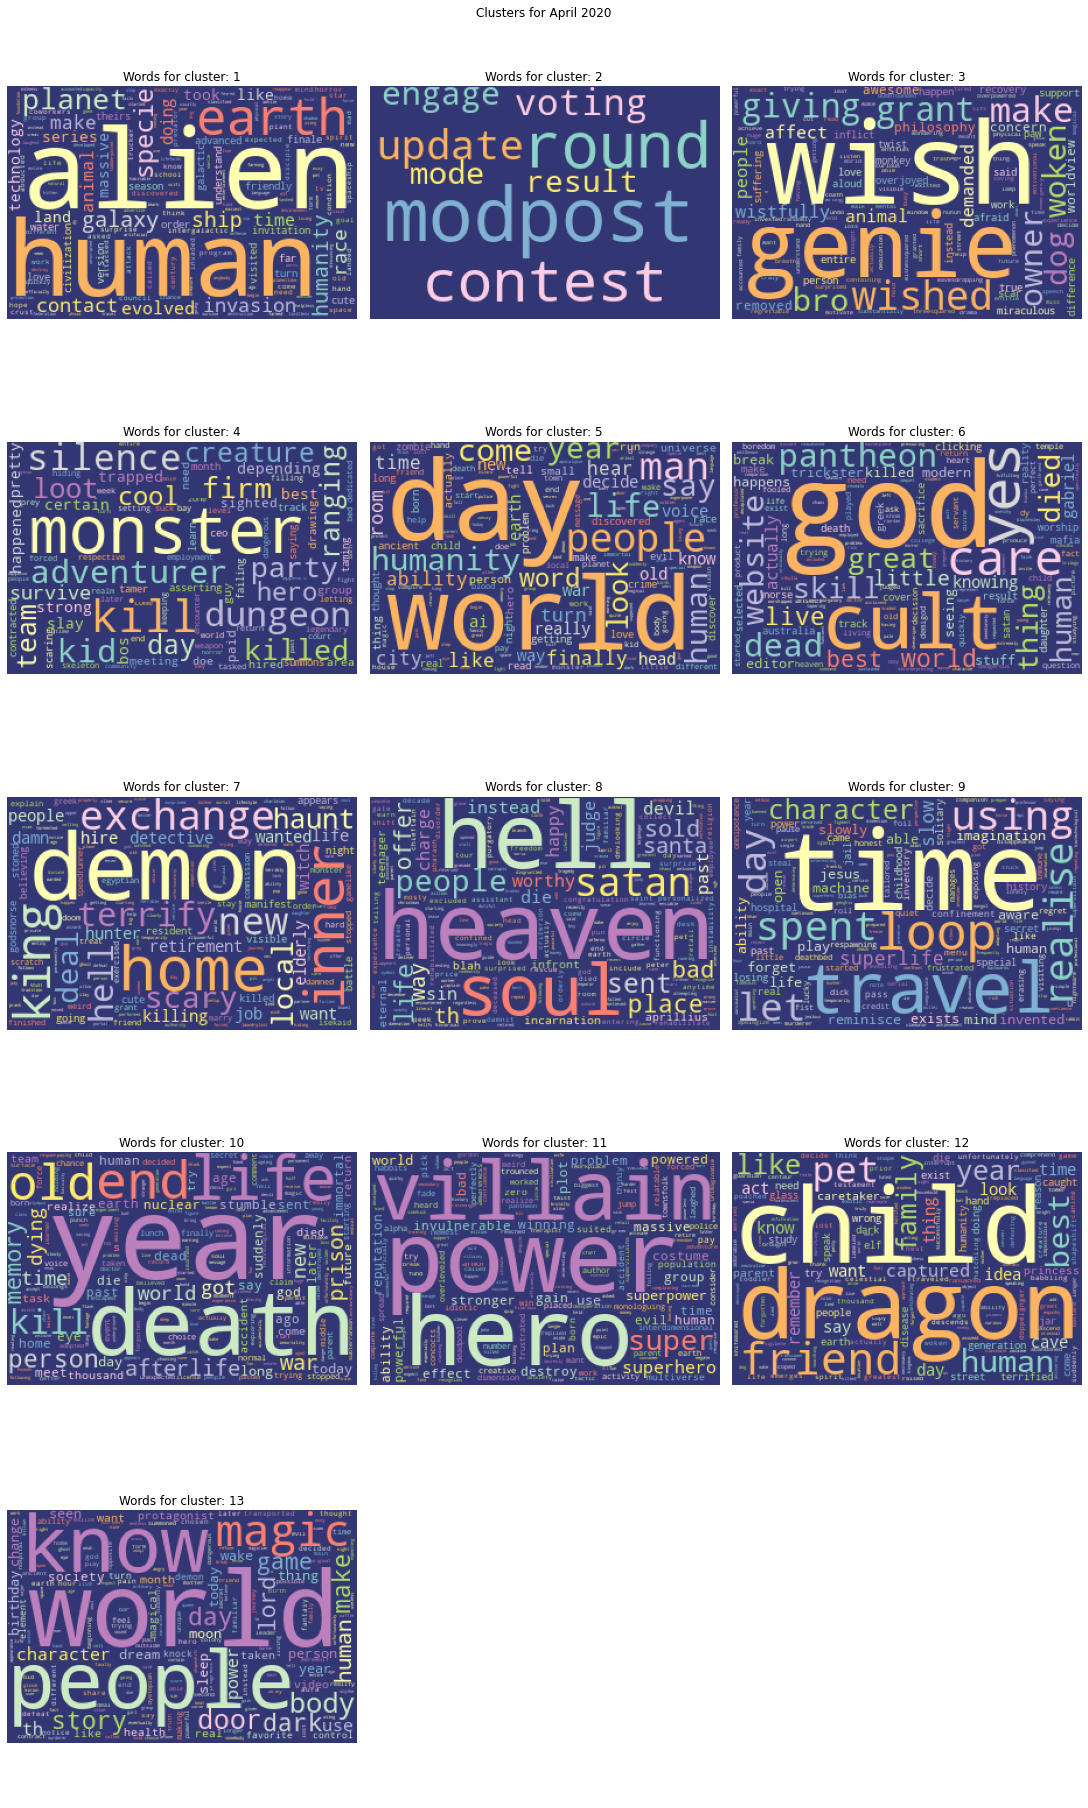

In [27]:
plot_cluster(all_data[3]['X'], c4['y_predict'], all_data[3]['feature_names'], 'April 2020')

<div align="center"> <h4 align="center"> Figure 15 Wordcloud for Apr 2020 </h4> </div>

**April 2020**

**Cluster 1 (Extraterrestrial Science Fiction)** – similar to Cluster 1 in Jan.

**Cluster 2 (Noise)** – non relevant features in the form of tags which didn’t follow the format of [tag]

**Cluster 3 (Wish fulfillment)** - has features wish, genie, woken, grant, given, etc. which suggests the theme of wish fulfillment. 

**Cluster 4 (Adventure)** - has features like adventurer, monster, silence creature, kill, dungeon, survive, etc. which suggests the teams of adventures in a fantasy world, possibly different from the Fantasy world because of the use of the non-specific monster feature.

**Cluster 5 (Fantasy)** – fantasy but has features focused on god, cult, pantheon

**Cluster 6 (Occult)** - similar to Cluster 4 in Jan

**Cluster 7 (Paranormal)** - similar Occult, but with the features haunt, home, terrify, hell, killing, etc. 

**Cluster 8 (Occult)** - similar to Cluster 4 in Jan

**Cluster 9 (Time Travel)** - similar to Cluster 5 in Jan.

**Cluster 10 (Death)** - similar to Cluster 6 in Jan.

**Cluster 11 (Superheroes)** - similar to Cluster 12 in Jan

**Cluster 12 (Children’s Fantasy)** – similar to Cluster 7 in Jan but has the additional features of dragon and pet, possibly a reference to How to Train Your Dragon.

**Cluster 13 (Noise)** – similar to Cluster 8 in Jan.

<br><br>

# Conclusion

Based of the clusters form each month, there are themes that are consistly stay at the top 10% of the posts in that subreddit. The themes are:

1. **Extraterrestrial Science** - Themes involving science fiction, space exploration, and alien life

2. **Superheroes** - Elements involving the superhero genre

3. **Magic** - Elements of magic

4. **Dungeons** - Medival fantasy with castles, knights, and dragons

5. **Occult** - Paranormal elements involving hell, demons, and cults

6. **Death** - Elements and plot devices with allusions to death

7. **Time Travel** - Themes involving time travel

Other themes that appeared in the top 10% during fewer months were:

1. **Media Inspired** - Fan adaptations of other media

2. **Other Worlds** - Themes involving other worlds

3. **Zombies** - Themes suggesting elements of a zombie apocalypse

4. **Cross Genre** - Mix of genres

5. **Paranormal** - Themes involving ghosts and haunting

6. **Children's Fantasy** - Fantasy worlds with children at the center of the plot

Over the span of 4 months, posters have been submitting prompts with the themes listed above and have been getting the top 10% number number of upvotes from members of subreddit. Perhaps it may be a good indicator of potential inspiration for creatives to draw from.

<br><br>

# Recommendations

Future improvements on the study:
1. There may be more insights to be had if the comments, the stories created based on the prompt, are used it the study as well. However, a challenge lies in clustering the data efficiently without causing the kernel to die.

2. Sentiment analysis with respect to the scores can be done as a next step with a comparison of the titles having lower 10% of the score and perform.

3. Comparison of posts from previous years can provide insight on the changing creative ideas over the years, if any.

<br><br>

# Acknowledgement and References

+ https://www.oberlo.com/blog/reddit-statistics
+ https://subredditstats.com/r/philippines
+ https://pushshift.io/api-parameters/
+ https://www.programcreek.com/python/example/124808/zstandard.ZstdDecompressor 
+ https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
+ https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
+ https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/
+ https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0
+ https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
+ https://www.kaggle.com/shivampanwar/tutorial-lda-vs-pca-and-topic-modelling-using-lda
+ https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
+ https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
+ Wordcloud mask from: https://www.kaggle.com/aashita/masks